In [ ]:
# !pip install -r requirements.txt

In [1]:
import inspect
from collections import Counter

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Data Exploration

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head(3)

,Prompt,Sequence of Nodes
0,Trigger an alert when a variable changes to 't...,"[OnVariableChange],[Alert],[Log]"
1,Assign a new value to a variable when it chang...,"[OnVariableChange],[Assign],[Show]"
2,Send a request when a variable changes and upd...,"[OnVariableChange],[SendRequest],[Update]"


In [5]:
df['Prompt'][0]

"Trigger an alert when a variable changes to 'true' and log the event."

In [6]:
df['Nodes List'] = df['Sequence of Nodes'].apply(lambda x: x.strip("[]").split("],["))
df['Nodes List'].head(3)

0             [OnVariableChange, Alert, Log]
1           [OnVariableChange, Assign, Show]
2    [OnVariableChange, SendRequest, Update]
Name: Nodes List, dtype: object

In [7]:
# Flatten the list of all nodes and count occurrences
all_nodes = [node for nodes_list in df['Nodes List'] for node in nodes_list]
node_counts = Counter(all_nodes)
# Convert the counter to a DataFrame for easy viewing
node_counts_df = pd.DataFrame(node_counts.items(), columns=['Node', 'Count'])
node_counts_df.head(3)

,Node,Count
0,OnVariableChange,20
1,Alert,13
2,Log,54


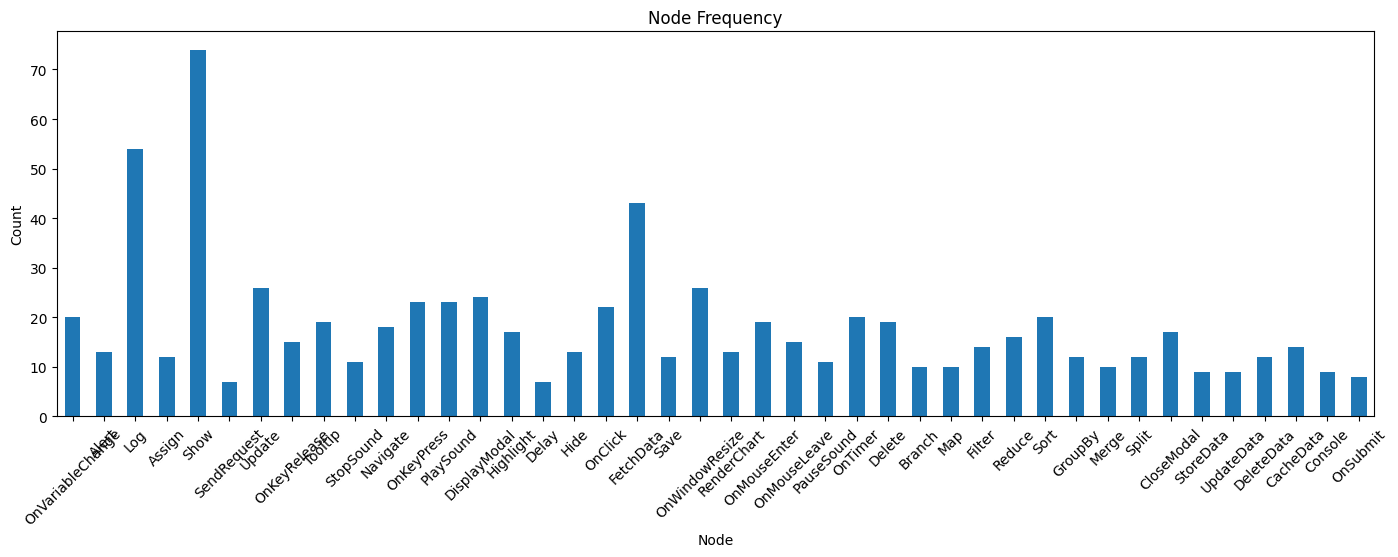

In [8]:
# Plot the counts as a histogram
plt.figure(figsize=[17, 5])
node_counts_df.plot(kind='bar', x='Node', y='Count', legend=False, ax=plt.gca())
plt.title('Node Frequency')
plt.xlabel('Node')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Print least repeated node names
node_counts_df[node_counts_df['Count'] == node_counts_df['Count'].min()]

,Node,Count
5,SendRequest,7
15,Delay,7


# Tokenize words and prepare dataset class

In [12]:
# Load the pre-trained GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
print('Special tokens:', tokenizer.all_special_tokens)
print('Numer of unique tokens:', len(tokenizer))

Special tokens: ['<|endoftext|>']
Numer of unique tokens: 50257


In [13]:
# Add a [STN] START OF NODES token to the tokenizer to force model predict node names after text prompt
SPECIAL_TOKEN_TO_PREDICT = ">>"
special_token_ids = tokenizer.encode(SPECIAL_TOKEN_TO_PREDICT)
print(
    f'The new token is supposed to force model predict nodes. It tokenizes to number of tokens: {len(special_token_ids)} : {special_token_ids}')

The new token is supposed to force model predict nodes. It tokenizes to number of tokens: 1 : [4211]


In [14]:
# Set a new padding token
"""
By default padding token is equal to end-of-text token in gpt2 tokenizer. 
This breaks logic when we want to keep end-of-text token to be presented between concatenated text pieces and in the labels too, 
becuase end-of-text presented between concatenated text pieces treated as padding and thus is ignored in GT labels.
"""
PADDING_TOKEN = "<|PAD|>"
special_tokens_dict = {'pad_token': PADDING_TOKEN}
tokenizer.add_special_tokens(special_tokens_dict)

1

In [15]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|PAD|>'}

In [14]:
len(tokenizer), tokenizer.encode(PADDING_TOKEN)

(50258, [50257])

### Create pandas dataframe with text ready to be tokenized

In [15]:
df['concatenated_node_names'] = df['Sequence of Nodes'].apply(
    lambda x: SPECIAL_TOKEN_TO_PREDICT + ' ' + ' '.join(x.strip("[]").split("],[")) + tokenizer.eos_token)
df['concatenated_node_names'].head(3)

0           >> OnVariableChange Alert Log<|endoftext|>
1         >> OnVariableChange Assign Show<|endoftext|>
2    >> OnVariableChange SendRequest Update<|endoft...
Name: concatenated_node_names, dtype: object

In [16]:
df['data'] = df['Prompt'] + df['concatenated_node_names']
df['data'].head(5)

0    Trigger an alert when a variable changes to 't...
1    Assign a new value to a variable when it chang...
2    Send a request when a variable changes and upd...
3    Display a tooltip with additional info when a ...
4    Log the release of a key and stop any playing ...
Name: data, dtype: object

In [17]:
sample_text = df['data'][0]
sample_tokens = tokenizer.encode(sample_text, truncation=True, max_length=tokenizer.model_max_length)
print('Sample text: ', sample_text)
print("Tokens: ", sample_tokens)
for token in sample_tokens[-4:]:
    print(f'\tToken:  {tokenizer.decode(token)} = {token}')

Sample text:  Trigger an alert when a variable changes to 'true' and log the event.>> OnVariableChange Alert Log<|endoftext|>
Tokens:  [48344, 281, 7995, 618, 257, 7885, 2458, 284, 705, 7942, 6, 290, 2604, 262, 1785, 32756, 1550, 43015, 19400, 23276, 5972, 50256]
	Token:  Change = 19400
	Token:   Alert = 23276
	Token:   Log = 5972
	Token:  <|endoftext|> = 50256


### Concatenate text into once sequence up to context length

In [18]:
raw_datasets = Dataset.from_pandas(df).train_test_split(test_size=0.2, seed=42)
train_df = pd.DataFrame(raw_datasets['train'])
val_df = pd.DataFrame(raw_datasets['test'])
val_df['data'].head(3)

0    Highlight a text box when the mouse enters and...
1    Highlight an element on mouse enter and hide t...
2    Display a modal dialog when a timer triggers e...
Name: data, dtype: object

In [19]:
def merge_sequences(dataframe_rows, max_context_window=1024):
    merged_sequences = []
    current_sequence = ''
    current_length = 0
    for text_to_tokens in dataframe_rows:
        tokens = tokenizer.encode(text_to_tokens)
        if current_length + len(tokens) <= max_context_window:
            current_sequence += text_to_tokens
            current_length += len(tokens)
        else:
            merged_sequences.append(current_sequence)
            # Start a new sequence
            current_sequence = text_to_tokens
            current_length = len(tokens)
    # Don't forget to add the last sequence
    if current_sequence:
        merged_sequences.append(current_sequence)
    return merged_sequences


# train_df['encoded_data'] = train_df['data'].apply(lambda x: tokenizer.encode(x))
# val_df['encoded_data'] = val_df['data'].apply(lambda x: tokenizer.encode(x))

train_concat_sequences = merge_sequences(train_df['data'], max_context_window=tokenizer.model_max_length)
val_concat_sequences = merge_sequences(val_df['data'], max_context_window=tokenizer.model_max_length)

for concat_lists in [train_concat_sequences, val_concat_sequences]:
    print('Length of concatenated sequences:', [len(tokenizer.encode(text)) for text in concat_lists])

Length of concatenated sequences: [1022, 1022, 1019, 1020, 941]
Length of concatenated sequences: [1009, 258]


In [20]:
train_concat_sequences

['Navigate to a new URL when a key is released>> OnKeyRelease Navigate<|endoftext|>Sort user comments by date and update the display to show the most recent comments at the top.>> Sort Update<|endoftext|>Fetch data when a key is pressed and show it in a modal.>> OnKeyPress FetchData DisplayModal<|endoftext|>Sort a list of items by date and then display the sorted list.>> Sort Show<|endoftext|>Pause a sound when a specific variable changes>> OnVariableChange PauseSound<|endoftext|>Play an alert sound when a form is submitted and show a confirmation message on the screen.>> OnSubmit PlaySound Show<|endoftext|>Hide an element when the window is resized.>> OnWindowResize Hide<|endoftext|>Log the current time whenever the window is resized and display the time on the screen.>> OnWindowResize Log Show<|endoftext|>Sort a list of items by date and then display the sorted list.>> Sort Show<|endoftext|>Display a modal when the mouse leaves a specific section.>> OnMouseLeave DisplayModal<|endofte

In [21]:
# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(pd.DataFrame(train_concat_sequences, columns=['text']))
val_dataset = Dataset.from_pandas(pd.DataFrame(val_concat_sequences, columns=['text']))

# Combine into a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'val': val_dataset
})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 5
    })
    val: Dataset({
        features: ['text'],
        num_rows: 2
    })
})

In [22]:
tokenizer.eos_token, tokenizer.eos_token_id

('<|endoftext|>', 50256)

In [23]:
# tokenizer.pad_token = tokenizer.eos_token
def tokenize(element):
    outputs = tokenizer(element["text"],
                        truncation=True,
                        max_length=tokenizer.model_max_length,
                        padding='max_length',
                        )
    return outputs


tokenized_datasets = dataset_dict.map(
    tokenize, batched=True, remove_columns=dataset_dict["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 5
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 2
    })
})

# Reshape embedding table in pre-trained GPT2 model for training and create training/validation loops

In [24]:
from transformers import GPT2LMHeadModel, set_seed

model = GPT2LMHeadModel.from_pretrained("gpt2")
# Prepare model for the new token embeddings
embedding_layer = model.resize_token_embeddings(
    len(tokenizer))  # Update the model embeddings with the new vocabulary size
assert model.transformer.wte.weight.data_ptr() == model.lm_head.weight.data.data_ptr(), "Weight sharing was broken in the transformer!"

## Training/validation loops

### Create a DataLoader classes

In [25]:
set_seed(42)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False, return_tensors="pt")
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=1, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["val"], shuffle=False, batch_size=2, collate_fn=data_collator
)

In [26]:
for batch in eval_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([2, 1024]),
 'attention_mask': torch.Size([2, 1024]),
 'labels': torch.Size([2, 1024])}

In [27]:
with torch.no_grad():
    outputs = model(**batch)
    print(outputs.loss, outputs.logits.shape)

tensor(94.5092) torch.Size([2, 1024, 50258])


In [28]:
tokenizer.decode(batch['input_ids'][0], skip_special_tokens=False)

"Highlight a text box when the mouse enters and display a tooltip.>> OnMouseEnter Highlight Tooltip<|endoftext|>Highlight an element on mouse enter and hide the highlight on mouse leave.>> OnMouseEnter Highlight OnMouseLeave Hide<|endoftext|>Display a modal dialog when a timer triggers every 5 seconds.>> OnTimer DisplayModal<|endoftext|>Log a message when the mouse enters a button area.>> OnMouseEnter Log<|endoftext|>Display an alert when the value of a specific variable is updated.>> OnVariableChange Alert<|endoftext|>Navigate to the dashboard page after successful login.>> Navigate Show<|endoftext|>Filter out irrelevant data and then merge the filtered data with another dataset before showing it.>> Filter Merge Show<|endoftext|>Split a large file into smaller segments and delete the original file>> Split Delete<|endoftext|>Hide an element's tooltip when the mouse leaves the element.>> OnMouseLeave Hide<|endoftext|>Save form data when a submit button is clicked.>> OnClick Save<|endoft

In [29]:
tokenizer.decode(batch['labels'][0][batch['labels'][0] != -100], skip_special_tokens=False)

"Highlight a text box when the mouse enters and display a tooltip.>> OnMouseEnter Highlight Tooltip<|endoftext|>Highlight an element on mouse enter and hide the highlight on mouse leave.>> OnMouseEnter Highlight OnMouseLeave Hide<|endoftext|>Display a modal dialog when a timer triggers every 5 seconds.>> OnTimer DisplayModal<|endoftext|>Log a message when the mouse enters a button area.>> OnMouseEnter Log<|endoftext|>Display an alert when the value of a specific variable is updated.>> OnVariableChange Alert<|endoftext|>Navigate to the dashboard page after successful login.>> Navigate Show<|endoftext|>Filter out irrelevant data and then merge the filtered data with another dataset before showing it.>> Filter Merge Show<|endoftext|>Split a large file into smaller segments and delete the original file>> Split Delete<|endoftext|>Hide an element's tooltip when the mouse leaves the element.>> OnMouseLeave Hide<|endoftext|>Save form data when a submit button is clicked.>> OnClick Save<|endoft

### Create custom training loop

In [30]:
model.to(device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the lm_head layer
model.transformer.wte.weight.requires_grad = True


# Function to print weights of all unfrozen layers
def print_unfrozen_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'Trainable Layer: {name}')


# Print weights of unfrozen layers
print_unfrozen_weights(model)

Trainable Layer: transformer.wte.weight


In [31]:
@torch.no_grad()
def generate_text(model, split, dataset):
    set_seed(42)
    gt_labels = []
    model_generated = []
    for i in tqdm(range(len(dataset[split]))):
        input_text = pd.DataFrame(dataset[split])['Prompt'][i] + SPECIAL_TOKEN_TO_PREDICT
        # Tokenize input
        input_ids = tokenizer.encode(input_text, return_tensors='pt')
        output = model.generate(input_ids=input_ids.to(device),
                                do_sample=True,
                                max_new_tokens=10,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                top_k=20,
                                top_p=0.95,
                                )

        # Decode the output
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
        pred_labels = decoded_output.split('>>')[1].strip()
        model_generated.append(pred_labels)

        gt_label = ' '.join(pd.DataFrame(dataset[split])['Nodes List'][i])
        gt_labels.append(gt_label)
    return model_generated, gt_labels


rouge = evaluate.load('rouge')


def compute_rouge(model, split, dataset):
    model.eval()
    model_generated, gt_labels = generate_text(model=model, split=split, dataset=dataset)
    results = rouge.compute(predictions=model_generated,
                            references=gt_labels,
                            use_aggregator=True,
                            use_stemmer=True,
                            )
    return results


compute_rouge(model=model, split='test', dataset=raw_datasets)

  0%|          | 0/62 [00:00<?, ?it/s]

{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}

In [32]:
def configure_optimizers(model, weight_decay, learning_rate, device_type):
    # start with all of the candidate parameters (that require grad)
    param_dict = {pn: p for pn, p in model.named_parameters()}
    param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]
    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
    print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
    # Create AdamW optimizer and use the fused version if it is available
    fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
    use_fused = fused_available and device_type == "cuda"
    optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
    return optimizer


optimizer = configure_optimizers(model=model, weight_decay=0.1, learning_rate=1e-3, device_type=device)

num decayed parameter tensors: 1, with 38,598,144 parameters
num non-decayed parameter tensors: 0, with 0 parameters


In [33]:
# @torch.no_grad()
# def eval_loop(model):
#     model.eval()
#     avg_loss = []
#     for batch in tqdm(eval_dataloader):
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         avg_loss.append(outputs.loss.item())
#     return np.mean(avg_loss)


best_val_rouge1 = -1


def train_loop(num_epochs, eval_every_epoch=2):
    global best_val_rouge1
    model.train()
    train_loss_list = []
    best_train_loss = float('inf')
    # best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print('Epoch: ', epoch)
        for batch in tqdm(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)  # clip grads
            optimizer.step()
            train_loss_list.append(loss.item())
        train_loss = np.mean(train_loss_list)
        print(f'Epoch {epoch} train loss: {round(train_loss, 4)}')
        train_loss_list = []
        if train_loss < best_train_loss:
            best_train_loss = train_loss
            torch.save(model, 'best_train_loss_model.pt')
        if epoch % eval_every_epoch and epoch > 0:
            print('\tEval...')
            rouge1 = compute_rouge(model=model, split='test', dataset=raw_datasets)['rouge1']
            model.train()
            print('\tEvaluation rouge1 score:', round(rouge1, 5), end=' <> ')
            if rouge1 > best_val_rouge1:
                best_val_rouge1 = rouge1
                torch.save(model, 'best_val_rouge1_model.pt')
            # val_loss = val_loss(model)
            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     torch.save(model, 'best_val_loss_model.pt')
            print('Best val rouge1 up to now: ', round(best_val_rouge1, 5))

In [34]:
train_loop(50)

Epoch:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 train loss: 88.3474
Epoch:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 train loss: 79.8437
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.0 <> Best val rouge1 up to now:  0.0
Epoch:  2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 train loss: 69.2924
Epoch:  3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 train loss: 62.0737
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.0 <> Best val rouge1 up to now:  0.0
Epoch:  4


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 train loss: 52.3361
Epoch:  5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 train loss: 45.5187
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.0 <> Best val rouge1 up to now:  0.0
Epoch:  6


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 train loss: 38.4625
Epoch:  7


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7 train loss: 31.616
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.0 <> Best val rouge1 up to now:  0.0
Epoch:  8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 train loss: 25.3893
Epoch:  9


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9 train loss: 19.6441
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.0 <> Best val rouge1 up to now:  0.0
Epoch:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 train loss: 14.6856
Epoch:  11


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11 train loss: 10.8752
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.0 <> Best val rouge1 up to now:  0.0
Epoch:  12


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12 train loss: 9.3438
Epoch:  13


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13 train loss: 7.2663
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.0 <> Best val rouge1 up to now:  0.0
Epoch:  14


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14 train loss: 5.849
Epoch:  15


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15 train loss: 5.0049
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.0 <> Best val rouge1 up to now:  0.0
Epoch:  16


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16 train loss: 4.3688
Epoch:  17


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17 train loss: 3.8199
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.0 <> Best val rouge1 up to now:  0.0
Epoch:  18


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18 train loss: 3.7683
Epoch:  19


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19 train loss: 3.3614
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.0 <> Best val rouge1 up to now:  0.0
Epoch:  20


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20 train loss: 3.0491
Epoch:  21


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21 train loss: 2.7776
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.00358 <> Best val rouge1 up to now:  0.00358
Epoch:  22


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22 train loss: 2.5491
Epoch:  23


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23 train loss: 2.3474
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.03353 <> Best val rouge1 up to now:  0.03353
Epoch:  24


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24 train loss: 2.2312
Epoch:  25


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25 train loss: 2.0587
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.06057 <> Best val rouge1 up to now:  0.06057
Epoch:  26


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26 train loss: 1.9466
Epoch:  27


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27 train loss: 1.8594
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.04139 <> Best val rouge1 up to now:  0.06057
Epoch:  28


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28 train loss: 1.7507
Epoch:  29


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29 train loss: 1.6924
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.04745 <> Best val rouge1 up to now:  0.06057
Epoch:  30


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30 train loss: 1.6511
Epoch:  31


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31 train loss: 1.5674
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.06857 <> Best val rouge1 up to now:  0.06857
Epoch:  32


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32 train loss: 1.4993
Epoch:  33


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33 train loss: 1.437
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.06868 <> Best val rouge1 up to now:  0.06868
Epoch:  34


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34 train loss: 1.3984
Epoch:  35


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35 train loss: 1.3594
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.11244 <> Best val rouge1 up to now:  0.11244
Epoch:  36


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36 train loss: 1.3105
Epoch:  37


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37 train loss: 1.2431
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.11014 <> Best val rouge1 up to now:  0.11244
Epoch:  38


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38 train loss: 1.2135
Epoch:  39


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39 train loss: 1.2024
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.16869 <> Best val rouge1 up to now:  0.16869
Epoch:  40


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40 train loss: 1.1614
Epoch:  41


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41 train loss: 1.1283
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.15484 <> Best val rouge1 up to now:  0.16869
Epoch:  42


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42 train loss: 1.0329
Epoch:  43


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43 train loss: 0.976
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.1482 <> Best val rouge1 up to now:  0.16869
Epoch:  44


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44 train loss: 1.0367
Epoch:  45


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45 train loss: 1.0138
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.1718 <> Best val rouge1 up to now:  0.1718
Epoch:  46


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46 train loss: 0.9973
Epoch:  47


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47 train loss: 0.9725
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.17374 <> Best val rouge1 up to now:  0.17374
Epoch:  48


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48 train loss: 0.9498
Epoch:  49


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49 train loss: 0.9323
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.18746 <> Best val rouge1 up to now:  0.18746


### Train the whole model

In [35]:
model = torch.load('best_val_rouge1_model.pt', map_location=device)
# unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Keep positional embeddings freezed
model.transformer.wpe.weight.requires_grad = False

# Use smaller LR
optimizer = configure_optimizers(model=model, weight_decay=0.1, learning_rate=1e-4, device_type=device)

num decayed parameter tensors: 49, with 123,532,800 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters


In [36]:
train_loop(50)

Epoch:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 train loss: 1.284
Epoch:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 train loss: 0.8933
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.32989 <> Best val rouge1 up to now:  0.32989
Epoch:  2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 train loss: 0.7545
Epoch:  3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 train loss: 0.6531
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.42963 <> Best val rouge1 up to now:  0.42963
Epoch:  4


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 train loss: 0.563
Epoch:  5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 train loss: 0.5104
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.51753 <> Best val rouge1 up to now:  0.51753
Epoch:  6


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 train loss: 0.4571
Epoch:  7


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7 train loss: 0.4094
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.55784 <> Best val rouge1 up to now:  0.55784
Epoch:  8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 train loss: 0.3783
Epoch:  9


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9 train loss: 0.3569
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.58696 <> Best val rouge1 up to now:  0.58696
Epoch:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 train loss: 0.3301
Epoch:  11


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11 train loss: 0.2938
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.50499 <> Best val rouge1 up to now:  0.58696
Epoch:  12


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12 train loss: 0.2866
Epoch:  13


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13 train loss: 0.2692
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.54653 <> Best val rouge1 up to now:  0.58696
Epoch:  14


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14 train loss: 0.198
Epoch:  15


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15 train loss: 0.1882
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.52213 <> Best val rouge1 up to now:  0.58696
Epoch:  16


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16 train loss: 0.2405
Epoch:  17


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17 train loss: 0.2194
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.49095 <> Best val rouge1 up to now:  0.58696
Epoch:  18


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18 train loss: 0.1809
Epoch:  19


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19 train loss: 0.1723
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.52024 <> Best val rouge1 up to now:  0.58696
Epoch:  20


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1975
Epoch:  21


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21 train loss: 0.1733
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.54529 <> Best val rouge1 up to now:  0.58696
Epoch:  22


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22 train loss: 0.1601
Epoch:  23


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23 train loss: 0.1532
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.59223 <> Best val rouge1 up to now:  0.59223
Epoch:  24


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24 train loss: 0.1369
Epoch:  25


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25 train loss: 0.1229
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.57127 <> Best val rouge1 up to now:  0.59223
Epoch:  26


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26 train loss: 0.11
Epoch:  27


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27 train loss: 0.0951
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.5942 <> Best val rouge1 up to now:  0.5942
Epoch:  28


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28 train loss: 0.0778
Epoch:  29


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29 train loss: 0.0737
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.54941 <> Best val rouge1 up to now:  0.5942
Epoch:  30


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30 train loss: 0.0596
Epoch:  31


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31 train loss: 0.0502
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.62682 <> Best val rouge1 up to now:  0.62682
Epoch:  32


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32 train loss: 0.0219
Epoch:  33


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33 train loss: 0.0164
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.4848 <> Best val rouge1 up to now:  0.62682
Epoch:  34


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34 train loss: 0.0413
Epoch:  35


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35 train loss: 0.0368
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.59781 <> Best val rouge1 up to now:  0.62682
Epoch:  36


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36 train loss: 0.0316
Epoch:  37


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37 train loss: 0.032
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.55349 <> Best val rouge1 up to now:  0.62682
Epoch:  38


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38 train loss: 0.0293
Epoch:  39


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39 train loss: 0.0291
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.58894 <> Best val rouge1 up to now:  0.62682
Epoch:  40


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40 train loss: 0.0218
Epoch:  41


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41 train loss: 0.0272
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.61788 <> Best val rouge1 up to now:  0.62682
Epoch:  42


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42 train loss: 0.0234
Epoch:  43


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43 train loss: 0.0253
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.62925 <> Best val rouge1 up to now:  0.62925
Epoch:  44


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44 train loss: 0.0197
Epoch:  45


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45 train loss: 0.0167
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.65356 <> Best val rouge1 up to now:  0.65356
Epoch:  46


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46 train loss: 0.0242
Epoch:  47


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47 train loss: 0.0202
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.6576 <> Best val rouge1 up to now:  0.6576
Epoch:  48


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48 train loss: 0.0137
Epoch:  49


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49 train loss: 0.0193
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.64058 <> Best val rouge1 up to now:  0.6576


# Evaluate the model and Generate outputs

In [51]:
model = torch.load('best_train_loss_model.pt', map_location=device)
model.eval();

In [52]:
raw_datasets;

In [53]:
compute_rouge(model=model, split='train', dataset=raw_datasets)

  0%|          | 0/244 [00:00<?, ?it/s]

{'rouge1': 0.6906754788926923,
 'rouge2': 0.5064207650273226,
 'rougeL': 0.6876024590163938,
 'rougeLsum': 0.6885287185492108}

In [54]:
compute_rouge(model=model, split='test', dataset=raw_datasets)

  0%|          | 0/62 [00:00<?, ?it/s]

{'rouge1': 0.6193932411674347,
 'rouge2': 0.43440860215053767,
 'rougeL': 0.615937019969278,
 'rougeLsum': 0.6181259600614438}

In [55]:
model = torch.load('best_val_rouge1_model.pt', map_location=device)
model.eval();

In [56]:
compute_rouge(model=model, split='train', dataset=raw_datasets)

  0%|          | 0/244 [00:00<?, ?it/s]

{'rouge1': 0.7123883743760799,
 'rouge2': 0.527576112412178,
 'rougeL': 0.7118757835970955,
 'rougeLsum': 0.7098900302793751}

In [57]:
compute_rouge(model=model, split='test', dataset=raw_datasets)

  0%|          | 0/62 [00:00<?, ?it/s]

{'rouge1': 0.6575958987249308,
 'rouge2': 0.40107526881720434,
 'rougeL': 0.6445925042699234,
 'rougeLsum': 0.6486333558914203}

In [47]:
# !pip freeze > requirements.txt

### Generate text

In [58]:
@torch.no_grad()
def print_generated_text(model, split, dataset):
    set_seed(42)
    for i in range(len(dataset[split])):
        input_text = pd.DataFrame(dataset[split])['Prompt'][i] + SPECIAL_TOKEN_TO_PREDICT

        # Tokenize input
        input_ids = tokenizer.encode(input_text, return_tensors='pt')
        output = model.generate(input_ids=input_ids.to(device),
                                do_sample=True,
                                max_new_tokens=10,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                top_k=20,
                                top_p=0.95,
                                )

        # Decode the output
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=False)

        print("Prompt text:")
        print(input_text)
        print("Generated text:")
        print(decoded_output)
        print('Label text:')
        print(' '.join(pd.DataFrame(dataset[split])['Nodes List'][i]))
        print('*' * 50 + f'{i}' + '*' * 50)

In [59]:
print_generated_text(model=model, split='test', dataset=raw_datasets)

Prompt text:
Highlight a text box when the mouse enters and display a tooltip.>>
Generated text:
Highlight a text box when the mouse enters and display a tooltip.>> OnMouseEnter Tooltip OnMouseLeave Hide<|endoftext|>
Label text:
OnMouseEnter Highlight Tooltip
**************************************************0**************************************************
Prompt text:
Highlight an element on mouse enter and hide the highlight on mouse leave.>>
Generated text:
Highlight an element on mouse enter and hide the highlight on mouse leave.>> OnMouseEnter Highlight OnMouseLeave Hide<|endoftext|>
Label text:
OnMouseEnter Highlight OnMouseLeave Hide
**************************************************1**************************************************
Prompt text:
Display a modal dialog when a timer triggers every 5 seconds.>>
Generated text:
Display a modal dialog when a timer triggers every 5 seconds.>> OnTimer Navigate<|endoftext|>
Label text:
OnTimer DisplayModal
**************************

 ### Generate list of the special tokens to detect if model engages unrelated node generation

In [22]:
all_gt_label_nodes = df['Sequence of Nodes'].apply(lambda x: ' '.join(x.strip("[]").split("],["))).values
all_gt_label_nodes[:5]

array(['OnVariableChange Alert Log', 'OnVariableChange Assign Show',
       'OnVariableChange SendRequest Update', 'OnKeyRelease Tooltip',
       'OnKeyRelease Log StopSound'], dtype=object)

In [20]:
label_token_list = []
for gt_label in tqdm(all_gt_label_nodes):
    tokens = tokenizer.encode(gt_label)
    label_token_list.extend(tokens)

  0%|          | 0/306 [00:00<?, ?it/s]

In [21]:
import pickle

# Save the list to a file
with open('gt_token_ids.pkl', 'wb') as file:
    pickle.dump(label_token_list, file)

### Used prompts to generate data using ChatGPT

Generate data for prompt to a sequence of nodes task. I will provide you the list of the possible event nodes and a few prompts to nodes examples. You need to generate more prompts and nodes examples for all the nodes in csv format. Generate 3 examples per each node. 
Possible nodes:
Event Nodes
[OnVariableChange]: Triggered when a specified variable changes value.
[OnKeyRelease]: Triggered when a key is released.
[OnKeyPress]: Triggered when a key is pressed.
[OnClick]: Triggered when an element is clicked.
[OnWindowResize]: Triggered when the window is resized.
[OnMouseEnter]: Triggered when the mouse pointer enters an element.
[OnMouseLeave]: Triggered when the mouse pointer leaves an element.
[OnTimer]: Triggered at specified time intervals.
Action Nodes
[Console]: Prints a message to the console.
[Alert]: Displays an alert message.
[Log]: Logs information for debugging purposes.
[Assign]: Assigns a value to a variable.
[SendRequest]: Sends a network request.
[Navigate]: Navigates to a different URL or page.
[Save]: Saves data to local storage or a database.
[Delete]: Deletes specified data or records.
[PlaySound]: Plays an audio file.
[PauseSound]: Pauses an audio file.
[StopSound]: Stops an audio file.
Transformation Nodes
[Branch]: Conditional node that branches based on a true/false evaluation.
[Map]: Transforms data from one format to another.
[Filter]: Filters data based on specified criteria.
[Reduce]: Reduces a list of items to a single value.
[Sort]: Sorts data based on specified criteria.
[GroupBy]: Groups data by a specified attribute.
[Merge]: Merges multiple datasets into one.
[Split]: Splits data into multiple parts based on criteria.
Display Nodes
[Show]: Displays information on the screen.
[Hide]: Hides information from the screen.
[Update]: Updates the display with new information.
[DisplayModal]: Displays a modal dialog.
[CloseModal]: Closes an open modal dialog.
[Highlight]: Highlights an element on the screen.
[Tooltip]: Shows a tooltip with additional information.
[RenderChart]: Renders a chart with specified data.
Data Nodes
[FetchData]: Fetches data from an API or database.
[StoreData]: Stores data in a variable or storage.
[UpdateData]: Updates existing data.
[DeleteData]: Deletes specified data.
[CacheData]: Caches data for performance improvement.

Examples
Prompt: Navigate to a new page after a delay of 3 seconds when the user clicks a button.
Sequence of Nodes:
1. [OnClick]
2. [Delay]
3. [Navigate]
Prompt: Fetch user data and display it in a modal when a button is clicked.
Sequence of Nodes:
1. [OnClick]
2. [FetchData]
3. [DisplayModal]
Prompt: Reduce a list of scores to find the highest score and log the result.
Sequence of Nodes:
1. [Reduce]
2. [Log]
Prompt: Cache fetched data to improve performance and display the data on the screen.
Sequence of Nodes:
1. [FetchData]
2. [CacheData]
3. [Show]
Prompt: Log a message when a key is pressed and display the key value on the screen.
Sequence of Nodes:
1. [OnKeyPress]
2. [Log]
3. [Show]
Prompt: Highlight an element when the mouse enters it and remove the highlight when the mouse leaves.Sequence of Nodes:
1. [OnMouseEnter]
2. [Highlight]
3. [OnMouseLeave]
4. [Show]
Prompt: Filter out items that are out of stock and sort the remaining items by price before displaying them on the screen.
Sequence of Nodes:
1. [Filter]
2. [Sort]
3. [Show]   

I will give you a few rows of a CSV file with columns of "Prompt"  and "Sequence of Nodes". You need to generate more similar examples in the same CSV format, but change the ordering of node names in the "Sequence of Nodes" column depending on the prompt text in the "Prompt" column. Remember that node ordering in the "Sequence of Nodes" column should follow the logic of the prompt text and, also, use only the provided examples of node names in "Sequence of Nodes". Do not create new node names apart from what is already used in the example. CSV examples with 4 rows.
Prompt,Sequence of Nodes
"Send a request when a variable changes and update the data displayed.","[OnVariableChange],[SendRequest],[Update]"
"Send a request to save form data when the submit button is clicked.","[OnClick],[SendRequest],[Save]"
"Send a network request when a key is pressed.","[OnKeyPress],[SendRequest]"
"Remove a specific record from the database after a successful network request","[SendRequest],[DeleteData]"